In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import glob
import nibabel as nb
import itertools
import json
import sys
import statsmodels.api as sm
from statsmodels.formula.api import ols

from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder


%matplotlib inline

In [4]:
kora_seg_paths = glob.glob('/home/abhijit/nas_drive/Data_WholeBody/KORA/KORA_segs/ROI_liver_spleen_Daniel/**/comp_mask.nii')
print(len(kora_seg_paths))
is_processed_labels = False

367


In [16]:
kora_seg_paths = glob.glob('/home/abhijit/Jyotirmay/my_thesis/dataset_groups/whole_body_datasets/KORA/processed_data/labels/**')
print(len(kora_seg_paths))
is_processed_labels = True

308


In [19]:
sample_count_dict = {}
for r_id, sample in enumerate(kora_seg_paths):
    print("\rProcessing {}/{}.".format(r_id, len(kora_seg_paths)), end="")
    if is_processed_labels:
        v_id = sample.split('/')[-1].split('.')[0]
    else:
        v_id = sample.split('/')[-2]

    s_data = nb.load(sample).get_fdata()
    unique_vals, counts = np.unique(s_data, return_counts=True)
    if len(counts) is not 3:
        print('not all class present, skipping!!')
        continue
    if v_id not in sample_count_dict.keys():
        sample_count_dict[v_id] = {}

    sample_count_dict[v_id]['seg_spleen'] = counts[2]
    sample_count_dict[v_id]['seg_liver'] = counts[1]


print(sample_count_dict)
df = pd.DataFrame.from_dict(sample_count_dict, orient="index")
df.to_csv(f'{is_processed_labels}sample_count_report.csv', index_label='volume_id')
df

Processing 307/308.{'KORA2453427': {'seg_spleen': 107934, 'seg_liver': 10821}, 'KORA2453578': {'seg_spleen': 162782, 'seg_liver': 12793}, 'KORA2457938': {'seg_spleen': 97145, 'seg_liver': 13146}, 'KORA2452930': {'seg_spleen': 163608, 'seg_liver': 24086}, 'KORA2453464': {'seg_spleen': 97311, 'seg_liver': 11320}, 'KORA2460191': {'seg_spleen': 121519, 'seg_liver': 14726}, 'KORA2456892': {'seg_spleen': 153044, 'seg_liver': 21842}, 'KORA2453262': {'seg_spleen': 110787, 'seg_liver': 14490}, 'KORA2459908': {'seg_spleen': 169516, 'seg_liver': 14040}, 'KORA2460697': {'seg_spleen': 200550, 'seg_liver': 36154}, 'KORA2452036': {'seg_spleen': 169178, 'seg_liver': 18734}, 'KORA2462405': {'seg_spleen': 129724, 'seg_liver': 18292}, 'KORA2452896': {'seg_spleen': 123610, 'seg_liver': 16420}, 'KORA2460371': {'seg_spleen': 149939, 'seg_liver': 22747}, 'KORA2461555': {'seg_spleen': 131241, 'seg_liver': 21606}, 'KORA2452291': {'seg_spleen': 128840, 'seg_liver': 16015}, 'KORA2460757': {'seg_spleen': 125616, 

,seg_spleen,seg_liver
KORA2453427,107934,10821
KORA2453578,162782,12793
KORA2457938,97145,13146
KORA2452930,163608,24086
KORA2453464,97311,11320
KORA2460191,121519,14726
KORA2456892,153044,21842
KORA2453262,110787,14490
KORA2459908,169516,14040
KORA2460697,200550,36154


In [20]:
df = pd.read_csv(f'{is_processed_labels}sample_count_report.csv')
df_k_feats = pd.read_csv('./dataset_groups/whole_body_datasets/KORA/processsed_csv_.csv')

In [21]:
df_merged = pd.merge(df, df_k_feats, how='inner', on=['volume_id'])
df_merged.to_csv(f'{is_processed_labels}concat_report_final.csv')
df = pd.read_csv(f'{is_processed_labels}concat_report_final.csv')

In [22]:
df_normal = df[df['diabetes_status']==0]
df_pre_diabetic = df[df['diabetes_status']==1]
df_diabetic = df[df['diabetes_status']==2]

In [23]:
df_normal_affx = df_normal.rename(columns=lambda x: 'normal_'+x)
df_pre_diabetic_affx = df_pre_diabetic.rename(columns=lambda x: 'pre_diabetic_'+x)
df_diabetic_affx = df_diabetic.rename(columns=lambda x: 'diabetic_'+x)
dfs = pd.concat([df_normal_affx, df_pre_diabetic_affx, df_diabetic_affx])

/home/abhijit/anaconda3/envs/tenv/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


normal_seg_spleen vs pre_diabetic_seg_spleen
t: -4.738713473030894
p: 3.5060629141588167e-06


normal_seg_spleen vs diabetic_seg_spleen
t: -7.172708062833062
p: 9.33633408318639e-12


diabetic_seg_spleen vs pre_diabetic_seg_spleen
t: 2.719398302668019
p: 0.007632988156583453


normal_seg_liver vs pre_diabetic_seg_liver
t: -2.7320392269522236
p: 0.006715818842019691


normal_seg_liver vs diabetic_seg_liver
t: -2.686697407737097
p: 0.007727116674720063


diabetic_seg_liver vs pre_diabetic_seg_liver
t: 0.5847595083100523
p: 0.5599404661887748




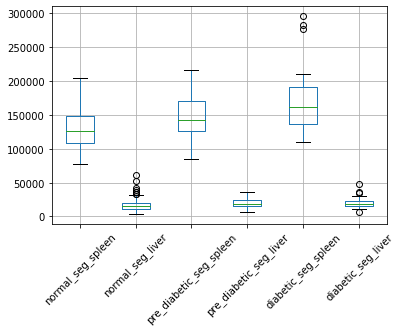

In [24]:
dfs[['normal_seg_spleen', 'normal_seg_liver', 'pre_diabetic_seg_spleen', 'pre_diabetic_seg_liver', 'diabetic_seg_spleen', 'diabetic_seg_liver']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_seg_spleen'].dropna().values, dfs[ 'pre_diabetic_seg_spleen'].dropna().values)

print('normal_seg_spleen vs pre_diabetic_seg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_seg_spleen'].dropna().values, dfs[ 'diabetic_seg_spleen'].dropna().values)
print('normal_seg_spleen vs diabetic_seg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_seg_spleen'].dropna().values, dfs[ 'pre_diabetic_seg_spleen'].dropna().values)
print('diabetic_seg_spleen vs pre_diabetic_seg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_seg_liver'].dropna().values, dfs[ 'pre_diabetic_seg_liver'].dropna().values)
print('normal_seg_liver vs pre_diabetic_seg_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_seg_liver'].dropna().values, dfs[ 'diabetic_seg_liver'].dropna().values)
print('normal_seg_liver vs diabetic_seg_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_seg_liver'].dropna().values, dfs[ 'pre_diabetic_seg_liver'].dropna().values)
print('diabetic_seg_liver vs pre_diabetic_seg_liver')
print('t:', t)
print('p:', p)
print('\n')